## Imports

In [0]:
import requests
import pandas as pd
import math

import json
from functools import reduce

# Matplotlib and seaborn for visualization at the end
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col, when, sum, when,lit, udf, to_timestamp, year, month, hour, dayofmonth

from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

## Grouping the features 

Group the features within weather related groups to load the data from the API.

METADATA

- **_temperature_2m_** (°C):  Air temperature at 2 meters above ground
- **_relative_humidity_2m_** (%): Relative humidity at 2 meters above ground
- **_dew_point_2m_** (°C): Dew point temperature at 2 meters above ground
- **_apparent_temperature_** (°C): Apparent temperature is the perceived feels-like temperature combining wind chill factor, relative humidity and solar radiation
- **_pressure_msl_** **_surface_pressure_** (hPa): Atmospheric air pressure reduced to mean sea level (msl) or pressure at surface. Typically pressure on mean sea level is used in meteorology. Surface pressure gets lower with increasing elevation.
- **_cloud_cover_** (%): Total cloud cover as an area fraction
- **_cloud_cover_low_** (%): Low level clouds and fog up to 3 km altitude
- **_cloud_cover_mid_** (%): Mid level clouds from 3 to 8 km altitude
- **_cloud_cover_high	Instant_** (%):	High level clouds from 8 km altitude
- **_wind_speed_10m_**, **_wind_speed_80m_**, **_wind_speed_120m_**, **_wind_speed_180m_** (km/h) Wind speed at 10, 80, 120 or 180 meters above ground. Wind speed on 10 meters is the standard level.
- **_wind_direction_10m_**, **_wind_direction_80m_**, **_wind_direction_120m_**, **_wind_direction_180m_**: Wind direction at 10, 80, 120 or 180 meters above ground
- **_wind_gusts_10m_** (km/h): Gusts at 10 meters above ground as a maximum of the preceding hour
- **_vapour_pressure_deficit_** (kPa): Vapour Pressure Deficit (VPD) in kilopascal (kPa). 
- **_evapotranspiration_** (mm): Evapotranspration from land surface and plants that weather models assumes for this location. Available soil water is considered. 1 mm evapotranspiration per hour equals 1 liter of water per spare meter.
- **_et0_fao_evapotranspiration_**: (mm) ET₀ Reference Evapotranspiration of a well watered grass field. Based on FAO-56 Penman-Monteith equations ET₀ is calculated from temperature, wind speed, humidity and solar radiation. Unlimited soil water is assumed. ET₀ is commonly used to estimate the required irrigation for plants.
- **_precipitation_** (mm) Total precipitation (rain, showers, snow) sum
- **_snowfall_**	(cm): Snowfall amount of the preceding hour in centimeters.
- **_precipitation_probability_**	(%): Probability of precipitation with more than 0.1 mm of the preceding hour. Probability is based on ensemble weather models with 0.25° (~27 km) resolution. 30 different simulations are computed to better represent future weather conditions.
- **_rain_**: (mm) Rain from large scale weather systems of the preceding hour in millimeter
- **_showers_**: (mm) Showers from convective precipitation in millimeters from the preceding hour
- **_snow_depth_** (meters): Snow depth on the ground
- **_visibility_** (meters): Viewing distance in meters. Influenced by low clouds, humidity and aerosols.

In [0]:
wind = ["wind_speed_10m", "wind_speed_120m", "wind_direction_10m", "wind_direction_120m", "wind_gusts_10m"]

cloud_cover = ["cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "visibility"]

temperature = ["apparent_temperature", "temperature_2m", "temperature_120m", "relative_humidity_2m", "dew_point_2m", "vapour_pressure_deficit"]

rain_snow = ["precipitation_probability", "precipitation", "rain", "showers", "snowfall", "snow_depth"]

pressure = ["surface_pressure", "pressure_msl"]

water_balance = ["evapotranspiration", "et0_fao_evapotranspiration"]


## Loading the data

In [0]:
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"

# create a dictionary to store the dataframes
dfs={}

# create a dictionary with the groups of features to be loaded
features = {
    'wind': wind, 
    'cloud_cover': cloud_cover, 
    'temperature': temperature, 
    'rain_snow': rain_snow,
    'pressure': pressure, 
    'water_balance': water_balance
    }

# loop that creates a pandas dataframe for each group of features
# after transform the pandas data frame into a spark dataframe and store it in the dictionary
for key, value in features.items():
	params = {
		# Lisbon coordinates
		"latitude": 38.716885,
		"longitude": -9.140233,
		# 2 Years of Historical data
		"start_date": "2023-05-01",
		"end_date": "2025-05-01",
		"hourly": value
	}

	response = requests.get(url, params=params)
	data = response.json()
	print(key)
	pdf = pd.DataFrame(data['hourly'])
	dfs[key] = spark.createDataFrame(pdf)

wind
cloud_cover
temperature
rain_snow
pressure
water_balance


In [0]:

dfs

Out[4]: {'wind': DataFrame[time: string, wind_speed_10m: double, wind_speed_120m: double, wind_direction_10m: bigint, wind_direction_120m: bigint, wind_gusts_10m: double],
 'cloud_cover': DataFrame[time: string, cloud_cover: bigint, cloud_cover_low: bigint, cloud_cover_mid: bigint, cloud_cover_high: bigint, visibility: double],
 'temperature': DataFrame[time: string, apparent_temperature: double, temperature_2m: double, temperature_120m: double, relative_humidity_2m: bigint, dew_point_2m: double, vapour_pressure_deficit: double],
 'rain_snow': DataFrame[time: string, precipitation_probability: void, precipitation: double, rain: double, showers: double, snowfall: double, snow_depth: double],
 'pressure': DataFrame[time: string, surface_pressure: double, pressure_msl: double],
 'water_balance': DataFrame[time: string, evapotranspiration: double, et0_fao_evapotranspiration: double]}

In [0]:
# see the columns of the wind df as an example
dfs['wind'].columns

Out[5]: ['time',
 'wind_speed_10m',
 'wind_speed_120m',
 'wind_direction_10m',
 'wind_direction_120m',
 'wind_gusts_10m']

In [0]:
# list of dataframes extracted from the dictionary
dfs_list = list(dfs.values())

# merge all DataFrames on the 'time' column with an outer join, reduce is used to simplify code so that we dont have to do all the joins one by one
sdf_merged = reduce(lambda left, right: left.join(right, on="time", how="outer"), dfs_list)


In [0]:

# see the merged spark dataframe
sdf_merged.printSchema()
display(sdf_merged.limit(10))

root
 |-- time: string (nullable = true)
 |-- wind_speed_10m: double (nullable = true)
 |-- wind_speed_120m: double (nullable = true)
 |-- wind_direction_10m: long (nullable = true)
 |-- wind_direction_120m: long (nullable = true)
 |-- wind_gusts_10m: double (nullable = true)
 |-- cloud_cover: long (nullable = true)
 |-- cloud_cover_low: long (nullable = true)
 |-- cloud_cover_mid: long (nullable = true)
 |-- cloud_cover_high: long (nullable = true)
 |-- visibility: double (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- temperature_120m: double (nullable = true)
 |-- relative_humidity_2m: long (nullable = true)
 |-- dew_point_2m: double (nullable = true)
 |-- vapour_pressure_deficit: double (nullable = true)
 |-- precipitation_probability: void (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- showers: double (nullable = true)
 |-- snowfall: double (nullable = 

time,wind_speed_10m,wind_speed_120m,wind_direction_10m,wind_direction_120m,wind_gusts_10m,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,apparent_temperature,temperature_2m,temperature_120m,relative_humidity_2m,dew_point_2m,vapour_pressure_deficit,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,surface_pressure,pressure_msl,evapotranspiration,et0_fao_evapotranspiration
2023-05-01T00:00,6.2,21.4,21,7,18.0,0,0,0,0,24140.0,16.3,16.6,16.2,73,11.8,0.51,null,0.0,0.0,0.0,0.0,0.0,1014.5,1018.3,0.01,0.01
2023-05-01T01:00,4.5,19.8,14,2,13.0,0,0,0,0,24140.0,16.3,16.5,16.4,73,11.6,0.51,null,0.0,0.0,0.0,0.0,0.0,1014.2,1018.0,0.01,0.0
2023-05-01T02:00,3.0,18.8,346,355,10.4,0,0,0,0,24140.0,16.1,16.3,16.7,69,10.6,0.58,null,0.0,0.0,0.0,0.0,0.0,1013.7,1017.5,0.01,0.0
2023-05-01T03:00,3.2,18.8,360,357,6.8,100,0,0,100,24140.0,15.7,16.1,16.7,67,10.0,0.61,null,0.0,0.0,0.0,0.0,0.0,1013.7,1017.5,0.01,0.0
2023-05-01T04:00,3.0,17.7,346,355,5.8,42,0,0,42,24140.0,15.6,16.1,16.7,66,9.7,0.62,null,0.0,0.0,0.0,0.0,0.0,1014.0,1017.8,0.01,0.0
2023-05-01T05:00,3.6,19.4,6,360,8.3,96,0,0,96,24140.0,15.4,16.0,16.6,66,9.7,0.62,null,0.0,0.0,0.0,0.0,0.0,1014.0,1017.8,0.01,0.0
2023-05-01T06:00,3.4,16.7,32,6,9.0,29,0,0,29,24140.0,15.3,15.8,16.6,68,9.9,0.58,null,0.0,0.0,0.0,0.0,0.0,1013.9,1017.7,0.01,0.03
2023-05-01T07:00,3.3,14.5,41,14,7.2,0,0,0,0,24140.0,16.4,16.6,16.6,70,11.1,0.57,null,0.0,0.0,0.0,0.0,0.0,1014.0,1017.8,0.01,0.05
2023-05-01T08:00,5.0,11.7,21,18,14.4,0,0,0,0,24140.0,18.5,19.0,16.9,59,10.8,0.9,null,0.0,0.0,0.0,0.0,0.0,1014.4,1018.2,0.04,0.17
2023-05-01T09:00,7.0,9.2,21,21,19.4,0,0,0,0,24140.0,20.7,21.5,18.7,50,10.6,1.28,null,0.0,0.0,0.0,0.0,0.0,1014.5,1018.3,0.09,0.32


## Check for missing values

In [0]:
for group_feat in dfs.keys(): # check missing values for each df in the dictionary for better visualization
    dfs[group_feat].select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in dfs[group_feat].columns]).show()


+----+--------------+---------------+------------------+-------------------+--------------+
|time|wind_speed_10m|wind_speed_120m|wind_direction_10m|wind_direction_120m|wind_gusts_10m|
+----+--------------+---------------+------------------+-------------------+--------------+
|   0|             0|              0|                 0|                  0|             0|
+----+--------------+---------------+------------------+-------------------+--------------+

+----+-----------+---------------+---------------+----------------+----------+
|time|cloud_cover|cloud_cover_low|cloud_cover_mid|cloud_cover_high|visibility|
+----+-----------+---------------+---------------+----------------+----------+
|   0|          0|              0|              0|               0|         0|
+----+-----------+---------------+---------------+----------------+----------+

+----+--------------------+--------------+----------------+--------------------+------------+-----------------------+
|time|apparent_temperatur

In [0]:
# drop the column that only contains missing values
sdf_merged = sdf_merged.drop("precipitation_probability")

## Create columns: years, months, hours and seasons

We created features for the month, the day, the hour and the season of each row to enhance our data exploration.

In [0]:

# Convert the time feature into a timestamp type and store it in "time_ts"
sdf_merged = sdf_merged.withColumn("time_ts", to_timestamp("time", "yyyy-MM-dd'T'HH:mm"))


In [0]:
# Use the "time_sp" column created to create "year", "month" and "hour" features
sdf_merged = sdf_merged.withColumn("year", year("time_ts")) \
       .withColumn("month", month("time_ts")) \
       .withColumn("day", dayofmonth("time_ts")) \
       .withColumn("hour", hour("time_ts"))

sdf_merged = sdf_merged.drop("time_ts")


In [0]:
# create the feature "season" groupping the months
sdf_merged = sdf_merged.withColumn(
    "season",
    when(col("month").isin(12, 1, 2), "Winter")
    .when(col("month").isin(3, 4, 5), "Spring")
    .when(col("month").isin(6, 7, 8), "Summer")
    .when(col("month").isin(9, 10, 11), "Autumn")
)


## Use SQL to do queries to explore the data

We will focus our analysis mainly on features that measure weather conditions between 2 to 10 meters above the ground since they are the most relevant to detect anomalies that affect people and infrastructures.

In [0]:
# Create a temporary view to query with sql
sdf_merged.createOrReplaceTempView("sdf_merged")

In [0]:
%sql
-- See the correlations between wind features
SELECT 
corr(wind_speed_10m,
 wind_direction_10m) AS correlation_speed10_direction10,
corr(wind_speed_10m, wind_speed_120m) AS correlation_speed10_speed120,
corr(wind_direction_10m, wind_direction_120m) AS correlation_direction10_direction120,
corr(wind_speed_10m, wind_gusts_10m) AS correlation_speed10_gusts10,
corr(wind_direction_10m, wind_gusts_10m) AS correlation_direction10_gusts10
FROM sdf_merged;

correlation_speed10_direction10,correlation_speed10_speed120,correlation_direction10_direction120,correlation_speed10_gusts10,correlation_direction10_gusts10
0.22535395172605127,0.8335900366635401,0.8971379164623488,0.9654900879984376,0.2838115525230414


In [0]:
%sql
-- See the correlations between wind and pressure features
SELECT 
corr(wind_gusts_10m, surface_pressure) AS correlation_gusts10_sufpress,
corr(wind_direction_10m, surface_pressure) AS correlation_direction10_sufpress,
corr(wind_gusts_10m, pressure_msl) AS correlation_gusts10_mslpress,
corr(wind_direction_10m, pressure_msl) AS correlation_direction10_mslpress,
corr(surface_pressure, pressure_msl) AS correlation_sufpress_mslpress
FROM sdf_merged;

correlation_gusts10_sufpress,correlation_direction10_sufpress,correlation_gusts10_mslpress,correlation_direction10_mslpress,correlation_sufpress_mslpress
-0.36874789845911354,-0.23048551948980378,-0.37107183364485835,-0.23296271591115925,0.9999431054037138


In [0]:
%sql
-- See the correlations between cloud_cover features
SELECT 
corr(cloud_cover_low, cloud_cover_mid) AS correlation_cloud_cover_low_mid,
corr(cloud_cover_low, cloud_cover_high) AS correlation_cloud_cover_low_high,
corr(cloud_cover, cloud_cover_low) AS correlation_cloud_cover_total_low,
corr(cloud_cover, cloud_cover_mid) AS correlation_cloud_cover_total_mid,
corr(cloud_cover, cloud_cover_high) AS correlation_cloud_cover_total_high
FROM sdf_merged;

correlation_cloud_cover_low_mid,correlation_cloud_cover_low_high,correlation_cloud_cover_total_low,correlation_cloud_cover_total_mid,correlation_cloud_cover_total_high
0.33749081873934844,0.17891933322203202,0.656320162621009,0.6139340777978612,0.7126915102538519


In [0]:
%sql
-- See the correlations between cloud_cover and precipitation and visibility features
SELECT 
corr(cloud_cover, visibility) AS correlation_cloud_cover_visibility,
corr(cloud_cover, precipitation) AS correlation_cloud_cover_precipitation,
corr(cloud_cover_low, visibility) AS correlation_cloud_cover_low_visibility,
corr(cloud_cover_low, precipitation) AS correlation_cloud_cover_low_precipitation,
corr(cloud_cover_mid, visibility) AS correlation_cloud_cover_mid_visibility,
corr(cloud_cover_mid, precipitation) AS correlation_cloud_cover_mid_precipitation,
corr(cloud_cover_high, visibility) AS correlation_cloud_cover_high_visibility,
corr(cloud_cover_high, precipitation) AS correlation_cloud_cover_high_precipitation,
corr(visibility, precipitation) AS correlation_visibility_precipitation
FROM sdf_merged;

correlation_cloud_cover_visibility,correlation_cloud_cover_precipitation,correlation_cloud_cover_low_visibility,correlation_cloud_cover_low_precipitation,correlation_cloud_cover_mid_visibility,correlation_cloud_cover_mid_precipitation,correlation_cloud_cover_high_visibility,correlation_cloud_cover_high_precipitation,correlation_visibility_precipitation
-0.29446838727792496,0.20861870992829679,-0.356588455712216,0.25644475936942585,-0.17504638580755047,0.30716432288673484,-0.15343674897138715,0.20471085784612247,-0.16496469058349522


In [0]:
%sql
-- See the correlations between temperature and humidity features
SELECT
corr(temperature_2m, apparent_temperature) AS correlation_temp_2m_aparent_temp,
corr(temperature_2m, relative_humidity_2m) AS correlation_temp_2m_hum_2m,
corr(temperature_2m, vapour_pressure_deficit) AS correlation_temp_2m_vap_press,
corr(relative_humidity_2m, vapour_pressure_deficit) AS correlation_hum_2m_vap_press
FROM sdf_merged;

correlation_temp_2m_aparent_temp,correlation_temp_2m_hum_2m,correlation_temp_2m_vap_press,correlation_hum_2m_vap_press
0.9768650399090282,-0.6727924920852607,0.8245400827585962,-0.9087539257547396


#### Conclusions regarding correlations
- Wind gusts is highly correlated with wind speed at 10m
- The mean sea level surface pressure if highly correlated with the surface pressure
- Total cloud cover is highly correlated with cloud cover low, mid and high
- Precipitation, visibility and cloud cover features show low correlations between them
- Temperature, apparent temperature and humidity are highly correlated

Features that are highly correlatted should not be both included in the clustering analysis. This correlation first approach helps us performing feature selection and address the best features to be used to detect anomalies.

In [0]:
%sql
-- See if there are rows where cloud cover is 100 and there is not 100 in any other cloud cover columns
SELECT *
FROM sdf_merged
WHERE cloud_cover = 100
  AND NOT (
    cloud_cover_low = 100 OR
    cloud_cover_mid = 100 OR
    cloud_cover_high = 100
  )

time,wind_speed_10m,wind_speed_120m,wind_direction_10m,wind_direction_120m,wind_gusts_10m,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,apparent_temperature,temperature_2m,temperature_120m,relative_humidity_2m,dew_point_2m,vapour_pressure_deficit,precipitation,rain,showers,snowfall,snow_depth,surface_pressure,pressure_msl,evapotranspiration,et0_fao_evapotranspiration,year,month,day,hour,season
2023-05-07T10:00,13.7,22.3,357,357,33.8,100,28,0,99,24140.0,21.3,21.8,18.5,58,13.2,1.1,0.0,0.0,0.0,0.0,0.0,1017.6,1021.4,0.15,0.4,2023,5,7,10,Spring
2023-05-09T02:00,8.0,24.0,350,351,19.1,100,50,0,99,24140.0,17.9,17.3,16.2,88,15.3,0.24,0.0,0.0,0.0,0.0,0.0,1020.9,1024.7,0.01,0.0,2023,5,9,2,Spring
2023-05-15T05:00,8.3,23.4,358,357,19.8,100,43,0,99,24140.0,13.1,13.9,12.8,84,11.3,0.25,0.0,0.0,0.0,0.0,0.0,1017.7,1021.6,0.01,0.0,2023,5,15,5,Spring
2023-05-17T19:00,15.2,31.5,353,354,40.3,100,0,39,99,24140.0,19.3,23.3,21.7,25,2.1,2.14,0.0,0.0,0.0,0.0,0.0,1009.8,1013.5,0.07,0.22,2023,5,17,19,Spring
2023-05-22T05:00,2.6,7.1,56,49,5.0,100,0,57,99,24140.0,15.1,14.7,15.3,86,12.4,0.23,0.0,0.0,0.0,0.0,0.0,1007.8,1011.6,-0.0,0.0,2023,5,22,5,Spring
2023-05-22T11:00,9.6,11.3,34,37,20.5,100,14,51,99,24140.0,22.0,21.8,18.3,52,11.5,1.26,0.0,0.0,0.0,0.0,0.0,1008.5,1012.2,0.11,0.46,2023,5,22,11,Spring
2023-05-23T10:00,9.7,14.4,51,53,26.3,100,1,30,99,24140.0,22.3,21.9,18.7,61,14.1,1.03,0.0,0.0,0.0,0.0,0.0,1008.0,1011.7,0.1,0.39,2023,5,23,10,Spring
2023-05-28T12:00,12.3,17.7,265,266,31.3,100,48,56,98,24140.0,22.4,21.8,18.2,60,13.7,1.05,0.0,0.0,0.0,0.0,0.0,1012.8,1016.6,0.16,0.47,2023,5,28,12,Spring
2023-05-28T22:00,4.0,12.1,260,297,13.0,100,2,84,99,24140.0,17.1,16.5,15.5,83,13.6,0.32,0.0,0.0,0.0,0.0,0.0,1012.8,1016.6,0.01,0.0,2023,5,28,22,Spring
2023-05-29T08:00,7.6,11.2,273,274,19.4,100,54,71,99,24140.0,17.8,17.6,15.2,79,13.9,0.42,0.0,0.0,0.0,0.0,0.0,1011.9,1015.7,0.04,0.14,2023,5,29,8,Spring


In [0]:
%sql
SELECT
-- check key statistics for temperature grouped by season
    season, year,
    AVG(temperature_2m) AS mean_temp,
    MIN(temperature_2m) AS min_temp,
    MAX(temperature_2m) AS max_temp,
    AVG(relative_humidity_2m) AS mean_hum,
    MIN(relative_humidity_2m) AS min_hum,
    MAX(relative_humidity_2m) AS max_hum
FROM sdf_merged
GROUP BY season, year
ORDER BY season

season,year,mean_temp,min_temp,max_temp,mean_hum,min_hum,max_hum
Autumn,2023,19.10453296703296,8.3,34.3,78.78754578754578,24,100
Autumn,2024,18.806227106227094,8.7,34.1,77.14835164835165,18,100
Spring,2023,19.45107526881719,13.6,31.5,62.534946236559136,17,100
Spring,2024,16.543795289855062,7.9,32.0,71.51041666666667,21,100
Spring,2025,14.802217741935484,7.7,27.9,77.48118279569893,26,100
Summer,2024,22.096739130434788,14.2,37.6,68.08876811594203,15,100
Summer,2023,23.060597826087005,14.8,38.8,64.19746376811594,14,100
Winter,2025,13.051341807909617,4.4,19.4,81.90819209039547,37,100
Winter,2024,13.385027472527447,4.8,22.0,82.56501831501832,43,100
Winter,2023,12.276209677419363,5.7,19.1,86.35483870967742,50,100


In [0]:
%sql
-- See key statistics for pressure at the mean sea level grouped by seson
SELECT
    season, year,
    AVG(pressure_msl) AS mean_msl_press,
    MIN(pressure_msl) AS min_msl_press,
    MAX(pressure_msl) AS max_sml_press
FROM sdf_merged
GROUP BY season, year
ORDER BY season

season,year,mean_msl_press,min_msl_press,max_sml_press
Autumn,2023,1016.7604395604399,993.1,1027.8
Autumn,2024,1017.1675366300364,998.8,1029.1
Spring,2023,1016.7595430107529,1008.8,1025.4
Spring,2024,1015.5202898550715,992.4,1030.6
Spring,2025,1012.3365591397834,989.9,1024.6
Summer,2024,1015.5298460144917,1008.2,1024.0
Summer,2023,1016.5163043478276,1005.8,1023.8
Winter,2025,1021.7656073446321,1001.3,1034.0
Winter,2024,1024.0233058608064,992.2,1038.3
Winter,2023,1024.8571236559146,1004.4,1036.7


In [0]:
%sql
-- Check for the hours where the precipitation dind't matched the sum of rain and showers
-- This is likely an an anomaly, because all this rows have snowfall and snow_depth equal to zero
-- Despite this, the values of precipitation and the sum og rain and showers are very close
-- Which indicates that this is probably a minor rouding problem
SELECT precipitation, rain, showers, snowfall, snow_depth
FROM sdf_merged
WHERE precipitation != rain + showers

precipitation,rain,showers,snowfall,snow_depth
0.4,0.0,0.3,0.0,0.0
1.9,0.0,1.8,0.0,0.0
6.0,3.1,2.8,0.0,0.0
0.5,0.2,0.4,0.0,0.0
0.9,0.7,0.2,0.0,0.0
0.1,0.1,0.1,0.0,0.0
0.1,0.1,0.1,0.0,0.0
1.0,0.5,0.4,0.0,0.0
1.4,0.1,1.3,0.0,0.0
0.9,0.7,0.2,0.0,0.0


In [0]:
%sql
-- Check the days where the apparent temperature was the same as the temperature 2m 
SELECT time, apparent_temperature, temperature_2m, (apparent_temperature - temperature_2m) AS temp_difference,
temperature_120m, relative_humidity_2m, dew_point_2m, vapour_pressure_deficit
FROM sdf_merged
WHERE apparent_temperature != temperature_2m
ORDER BY ABS(apparent_temperature - temperature_2m) DESC
LIMIT 10

time,apparent_temperature,temperature_2m,temp_difference,temperature_120m,relative_humidity_2m,dew_point_2m,vapour_pressure_deficit
2025-03-20T02:00,8.3,14.0,-5.699999999999999,12.7,82,11.0,0.29
2025-03-20T04:00,6.9,12.2,-5.299999999999999,10.7,79,8.6,0.3
2023-08-23T11:00,36.0,30.9,5.100000000000001,27.5,58,21.7,1.88
2024-12-09T12:00,8.9,13.8,-4.9,11.2,43,1.5,0.9
2025-03-20T01:00,9.7,14.6,-4.9,13.4,85,12.1,0.25
2024-12-08T12:00,9.8,14.7,-4.899999999999999,12.1,47,3.5,0.89
2024-12-09T13:00,9.6,14.4,-4.800000000000001,11.7,46,3.0,0.89
2025-01-30T12:00,9.4,14.2,-4.799999999999999,11.8,53,4.7,0.76
2024-12-09T11:00,7.9,12.7,-4.799999999999999,10.3,46,1.4,0.8
2025-03-20T00:00,9.8,14.6,-4.799999999999999,13.5,89,12.8,0.18


In [0]:
%sql
-- Check the days with the higher daily temperature range
SELECT
  season,
  year,
  month,
  day,
  MAX(CASE WHEN hour = 3 THEN temperature_2m END) AS temp_at_3,
  MAX(CASE WHEN hour = 15 THEN temperature_2m END) AS temp_at_15,
  ABS(MAX(CASE WHEN hour = 3 THEN temperature_2m END) - 
      MAX(CASE WHEN hour = 15 THEN temperature_2m END)) AS temp_diff
FROM sdf_merged
WHERE hour IN (3, 15)
GROUP BY year, month, day, season
ORDER BY temp_diff DESC
LIMIT 15


season,year,month,day,temp_at_3,temp_at_15,temp_diff
Summer,2023,6,23,19.1,35.9,16.799999999999997
Summer,2024,8,15,20.0,36.6,16.6
Summer,2023,8,5,20.0,36.5,16.5
Summer,2023,8,6,21.9,38.3,16.4
Summer,2024,8,4,19.7,35.3,15.599999999999998
Summer,2023,7,17,16.5,31.8,15.3
Spring,2024,5,30,16.8,31.9,15.099999999999998
Spring,2024,5,28,14.6,29.5,14.9
Summer,2023,8,24,21.0,35.8,14.799999999999997
Summer,2024,7,22,18.1,32.7,14.600000000000001


## Visualizations using pandas

Based on the insights from the correlations first analysis we decided to do visualizations regarding the following features:
- **_temperature_2m_**: it is an important feature regarding anomaly detection, other features highly correlated with this one, like humidity, were droped
- **_wind_gusts_10m_**: the only feature kept regarding wind, all the others are highly correlated with this one
- **_cloud_cover_**: this is the total cloud cover, highly correlatd with other features within the same group so it will be the only kept
- **_visibility_**: a feature that is imporant to address once it affects everyday life. It is not highly correlated with any other
- **_precipitation_**: important feature to be kept, it is not highly correlated with the others
- **_pressure_msl_**: not strongly correlated with any of the others, it is normaly important for storm tracking

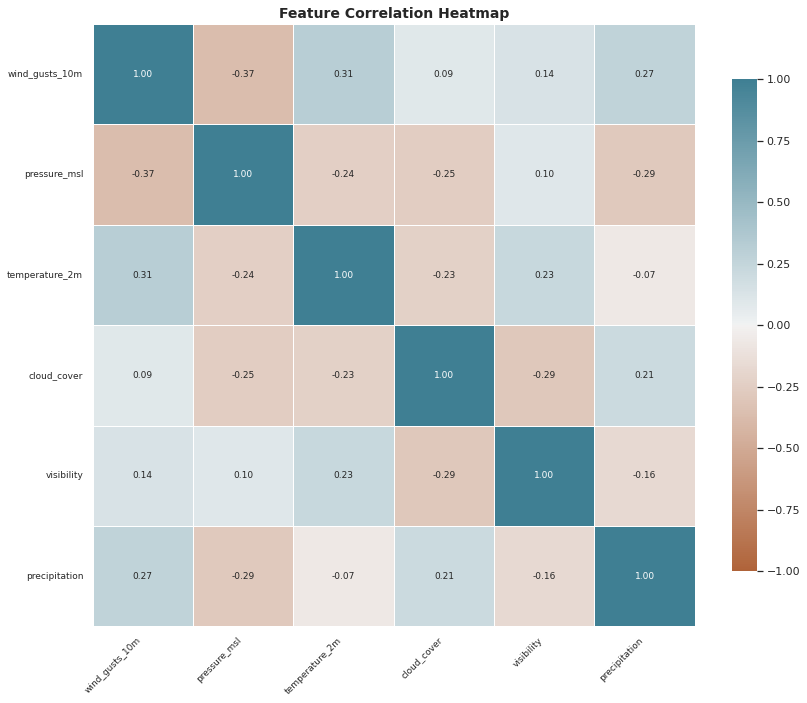

In [0]:
# correlation heatmap between selected features
feature_cols = ['wind_gusts_10m', 'pressure_msl', 'temperature_2m', 'cloud_cover', 'visibility',  'precipitation', 'year', 'month', 'season', 'hour']

# convert Spark DataFrame to Pandas
pdf = sdf_merged.select(feature_cols).toPandas()

# correlation matrix
corr_matrix = pdf[['wind_gusts_10m', 'pressure_msl', 'temperature_2m', 'cloud_cover', 'visibility',  'precipitation']].corr()

plt.figure(figsize=(12, 10))
sns.set(style="white")

# Color palette with orange and blue
cmap = sns.diverging_palette(30, 220, as_cmap=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9}
)

plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()



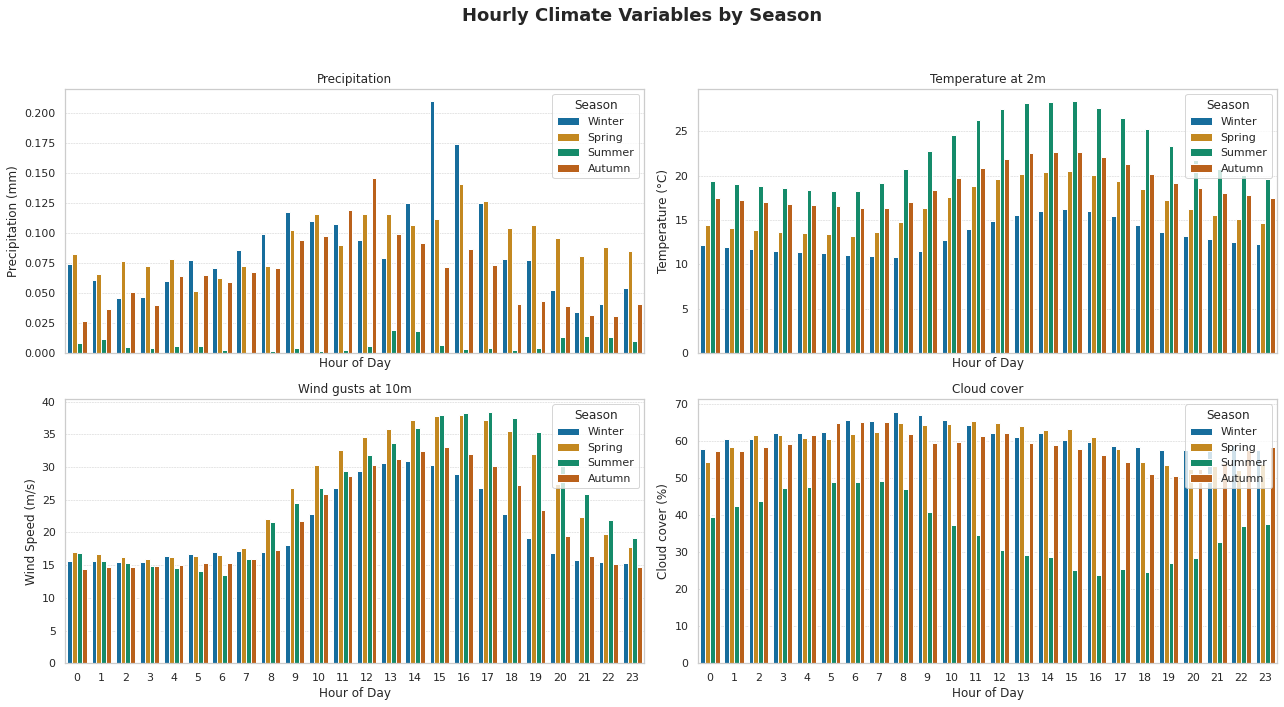

In [0]:
# Group and process data
grouped = pdf.groupby(['hour', 'season']).agg({
    'precipitation': 'mean',
    'temperature_2m': 'mean',
    'wind_gusts_10m': 'mean',
    'cloud_cover': 'mean'
}).reset_index()

# Season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
grouped['season'] = pd.Categorical(grouped['season'], categories=season_order, ordered=True)

sns.set_theme(style='whitegrid')
palette = sns.color_palette("colorblind")


fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

# See the evolution of humidity, temperature, wind gusts and cloud cover across the hours of the day per season
sns.barplot(data=grouped, x='hour', y='precipitation', hue='season', ax=axs[0, 0], palette=palette)
axs[0, 0].set_title('Precipitation')
axs[0, 0].set_ylabel('Precipitation (mm)')

sns.barplot(data=grouped, x='hour', y='temperature_2m', hue='season', ax=axs[0, 1], palette=palette)
axs[0, 1].set_title('Temperature at 2m')
axs[0, 1].set_ylabel('Temperature (°C)')

sns.barplot(data=grouped, x='hour', y='wind_gusts_10m', hue='season', ax=axs[1, 0], palette=palette)
axs[1, 0].set_title('Wind gusts at 10m')
axs[1, 0].set_ylabel('Wind Speed (m/s)')

sns.barplot(data=grouped, x='hour', y='cloud_cover', hue='season', ax=axs[1, 1], palette=palette)
axs[1, 1].set_title('Cloud cover')
axs[1, 1].set_ylabel('Cloud cover (%)')

for ax in axs.flat:
    ax.set_xlabel('Hour of Day')
    ax.legend(title='Season', loc='upper right')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.suptitle('Hourly Climate Variables by Season', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


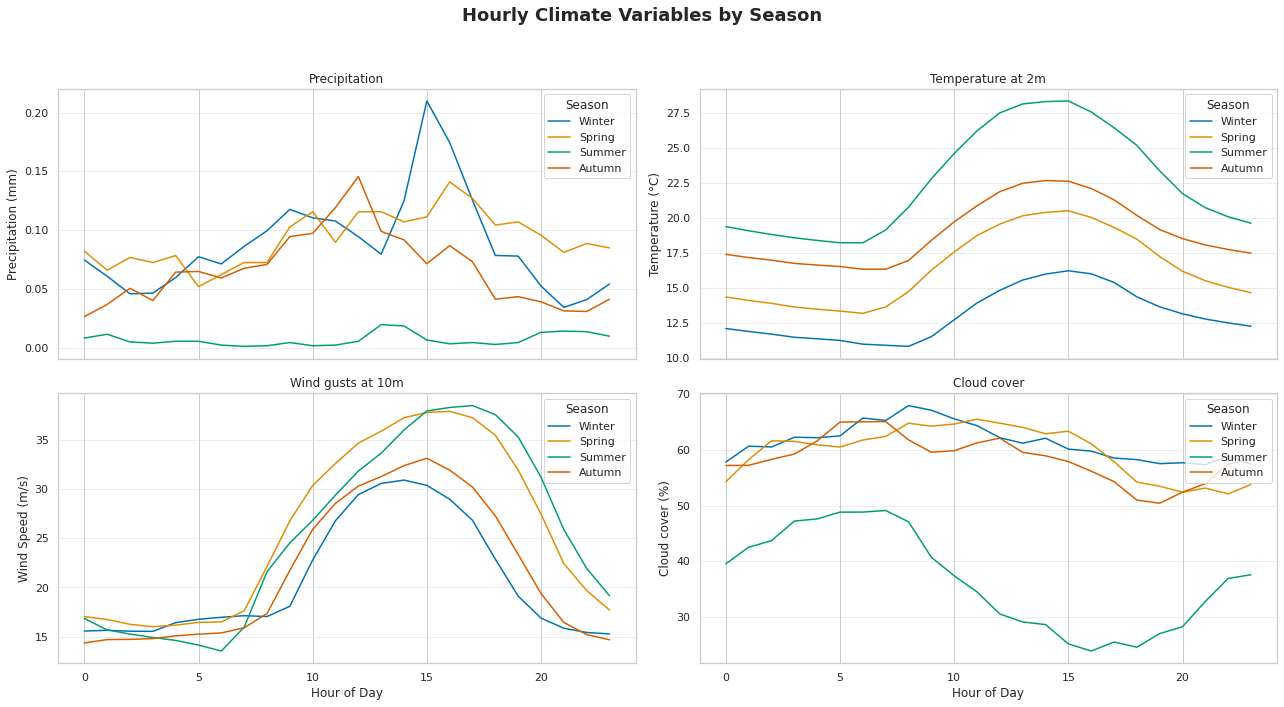

In [0]:
# Group and process data
grouped = pdf.groupby(['hour', 'season']).agg({
    'precipitation': 'mean',
    'temperature_2m': 'mean',
    'wind_gusts_10m': 'mean',
    'cloud_cover': 'mean'
}).reset_index()

# Season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
grouped['season'] = pd.Categorical(grouped['season'], categories=season_order, ordered=True)

sns.set_theme(style='whitegrid')
palette = sns.color_palette("colorblind", n_colors=len(season_order)) 

fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

# Line plots for each variable by hour and season
sns.lineplot(data=grouped, x='hour', y='precipitation', hue='season', ax=axs[0, 0], palette=palette)
axs[0, 0].set_title('Precipitation')
axs[0, 0].set_ylabel('Precipitation (mm)')

sns.lineplot(data=grouped, x='hour', y='temperature_2m', hue='season', ax=axs[0, 1], palette=palette)
axs[0, 1].set_title('Temperature at 2m')
axs[0, 1].set_ylabel('Temperature (°C)')

sns.lineplot(data=grouped, x='hour', y='wind_gusts_10m', hue='season', ax=axs[1, 0], palette=palette)
axs[1, 0].set_title('Wind gusts at 10m')
axs[1, 0].set_ylabel('Wind Speed (m/s)')

sns.lineplot(data=grouped, x='hour', y='cloud_cover', hue='season', ax=axs[1, 1], palette=palette)
axs[1, 1].set_title('Cloud cover')
axs[1, 1].set_ylabel('Cloud cover (%)')

# Common formatting
for ax in axs.flat:
    ax.set_xlabel('Hour of Day')
    ax.legend(title='Season', loc='upper right')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.suptitle('Hourly Climate Variables by Season', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Final Conclusions



Final features do be used for anomaly detection algorithms:
- **_temperature_2m_**
- **_wind_gusts_10m_**
- **_cloud_cover_**
- **_precipitation_**

These two features can be tested with carefull regarding the dimensionality problem with clustering
- **_pressure_msl_**
- **_visibility_**